Здесь представлен один из способов определения местоположения средствами Wi-Fi - <b>позиционирование по шаблону радио-окружения (Location patterning method)</b>. Данный метод рассматривается как самый простой и точный метод позиционирования в <b>indoor-среде</b> среди всех доступных методов (Nearest AP, ToA, TDoA, AoA, RSS), так как он способен учитывать реальную радио-обстановку области позиционирования с учетом ее особенностей распространения сигнала и не требует каких-либо дополнительных аппаратных средств (полностью реализуем программно).    

In [198]:
# Импорт модулей для моделирования
import numpy as np
import matplotlib.pyplot as plt
# Данные пакеты не входят в стандартную поставку интерпретатора Python, их нужно загружать отдельно

<b>Суть метода</b>: необходимо взять карту области, на которой будет осуществляться позиционирование, и поверх нее наложить сетку, содержащую <b>H</b> горизонтальных и <b>V</b> вертикальных линий. На пересечении горизонтальных и вертикальных линий сетки  образуются точки. В каждой из этих точек необходимо снять значение RSSI <b>для всех точек доступа</b>, сигнал которых присутствует в данной точке пространства. Сами точки доступа нужно расставлять таким образом, чтобы из каждой точки области позиционирования было видно не менее 3-х точек доступа (чем больше точек доступа, тем выше точность позиционирования). Тем самым будет получена карта радио-пространства <b>radio_map</b>, которая содержит измерения RSSI в каждой точке пространства для каждой точки доступа на всей карте области позиционирования. 

<b>Расмотрим конкретный пример</b>.
Область позиционирования представлена на рисунке ниже. Это две комнаты одинаковой площадью 20x20 м<sup>2</sup>.
<img src="pattern.png"/>

Теперь на эту площадь необходимо наложить сетку для определения точек снятия RSSI. Количество вертикальньных и горизонтальных линий в сетке нужно подбирать таким образом, чтобы точки пересечения покрывали всю карту области позиционирования, где в принципе могут находиться мобильные клиенты. Кроме того, соседние точки пересечения, находящиеся на одной линии, должны находиться друг от друга на физическом расстоянии <b>не более 1 метра</b>, для того, чтобы можно было обеспечить высокую точность позиционирования. То есть, тем больше точек для снятия RSSI в области позиционирования, тем точнее можно будет определять местоположение мобильных клиентов.

Выберем количество горизонтальных линий сетки равным 19 (<b>H = 19</b>) и количество вертикальных линий сетки равным 38 (<b>V = 38</b>), для того, чтобы обеспечить снятие характеристик RSSI на каждом метре области позиционирования. Такой выбор связан с тем, что нет необходимости располагать линии сетки вдоль стен. Наложим полученную сетку на область позиционирования.
<img src="pattern_with_grid.png"/>

<b>Координаты точки</b> в области позиционирования определяются как $(h;v)$, где $h$ - номер горизонтальной линии сетки (от 0 до H-1), $v$ - номер вертикальной линии сетки (от 0 до V-1). Такое представление координат точек пространства позволит организовать матрицу размера HxV, где каждая ячейка матрицы будет представлять собой конкретную точку области позиционирования. Например, координата (10;15) будет указывать на точку области позиционирования, которая находится на пересечении 10-й горизонтальной линии сетки и 15-й вертикальной линии сетки.

Далее необходимо расставить точки доступа Wi-Fi по территории области позиционирования. Это нужно сделать так, чтобы из каждой точки пересечения горизонтальных и вертикальных линий сетки можно было поймать сигнал не менее 3-х точек доступа. Точки доступа жалательно расставлять по периметру помещений. В данном случае <b>минимально необходимое расположение точек доступа</b>, обеспечивающее высокую точность позиционирования, выглядит следующим образом:
<img src="pattern_with_grid_and_ap.png"/>

Теперь в каждой из HxV имеющихся точек области позиционирования небходимо измерить уровень сигнала (RSSI) от всех 4-х точек доступа и записать результаты измерения в трехмерный массив <b>radio_map</b>. Данный массив имеет размерность NxHxV, где N-количество точек доступа во всей области позиционирования, а H и V - количество горизонтальных и вертикальных линий сетки соответственно.

In [199]:
# Пример содержимого radio_map для рассматриваемой области позиционирования
# Значение RSSI=-255 соответствует отсутствию сигнала от данной точки доступа в данной точке области позиционирования

radio_map = np.array([
    [[-10,-12,-15,-17,-21,-22,-25,-28,-31,-34,-37,-40,-41,-45,-47,-49,-51,-53,-55,-65,-71,-77,-83,-85,-94,-99,-107,-119,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-12,-14,-17,-22,-24,-27,-30,-33,-35,-39,-42,-44,-45,-47,-48,-49,-52,-54,-59,-65,-72,-78,-84,-85,-94,-100,-108,-120,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-15,-17,-22,-26,-29,-30,-33,-36,-41,-43,-45,-49,-53,-57,-61,-64,-67,-69,-73,-78,-84,-87,-95,-101,-108,-115,-137,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-17,-21,-23,-26,-27,-31,-34,-36,-41,-44,-47,-49,-52,-54,-56,-59,-63,-65,-67,-73,-76,-79,-84,-91,-97,-104,-113,-121,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-21,-22,-25,-28,-31,-34,-37,-40,-42,-44,-47,-49,-51,-55,-59,-63,-67,-69,-73,-79,-84,-87,-93,-98,-105,-111,-117,-124,-137,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-22,-25,-27,-30,-33,-36,-39,-43,-46,-48,-50,-52,-56,-59,-63,-64,-66,-68,-68,-74,-78,-83,-91,-97,-106,-115,-121,-137,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-25,-28,-31,-34,-35,-38,-43,-48,-49,-50,-52,-54,-57,-61,-65,-67,-69,-72,-72,-80,-84,-87,-92,-99,-110,-127,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-28,-32,-34,-37,-39,-42,-47,-52,-53,-53,-56,-57,-59,-64,-68,-70,-73,-75,-75,-83,-88,-90,-96,-104,-115,-137,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-31,-34,-38,-40,-43,-46,-50,-54,-55,-55,-59,-60,-62,-66,-71,-74,-76,-79,-80,-89,-91,-95,-100,-109,-127,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-34,-37,-39,-44,-46,-49,-53,-57,-59,-59,-61,-63,-65,-69,-73,-76,-79,-83,-83,-93,-94,-98,-104,-115,-127,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-37,-40,-43,-47,-48,-53,-57,-60,-63,-62,-63,-65,-68,-72,-76,-79,-82,-85,-86,-96,-96,-104,-108,-127,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-40,-43,-46,-49,-51,-56,-60,-63,-67,-64,-66,-69,-72,-75,-79,-82,-84,-89,-89,-98,-99,-108,-115,-130,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-42,-46,-49,-53,-54,-58,-62,-67,-69,-67,-68,-72,-75,-79,-83,-84,-86,-92,-94,-103,-103,-115,-120,-137,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-44,-48,-51,-56,-57,-62,-64,-71,-74,-70,-71,-75,-78,-82,-86,-87,-89,-95,-97,-107,-108,-127,-137,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-47,-51,-54,-59,-59,-65,-68,-74,-77,-73,-74,-79,-82,-85,-89,-90,-92,-97,-100,-112,-115,-127,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-49,-53,-57,-63,-63,-68,-71,-77,-79,-75,-77,-84,-85,-88,-92,-93,-95,-100,-104,-115,-123,-129,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-52,-56,-61,-67,-67,-73,-74,-79,-82,-79,-81,-87,-88,-90,-95,-96,-97,-104,-107,-119,-127,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-54,-59,-64,-69,-72,-75,-77,-81,-84,-84,-85,-88,-90,-93,-98,-99,-102,-107,-110,-125,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255],
    [-57,-65,-69,-73,-76,-78,-82,-84,-86,-88,-90,-90,-92,-96,-101,-103,-105,-110,-115,-127,-140,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255]],
    
    [[-56,-55,-53,-51,-48,-46,-44,-43,-39,-36,-33,-30,-27,-24,-22,-19,-15,-12,-10,-20,-23,-25,-27,-29,-32,-34,-36,-39,-43,-45,-49,-53,-56,-59,-63,-66,-69, -73],
    [-61,-59,-56,-55,-53,-50,-47,-44,-42,-39,-36,-32,-31,-28,-25,-23,-18,-15,-12,-23,-25,-27,-29,-32,-34,-36,-40,-43,-46,-50,-53,-57,-60,-63,-66,-69,-72,-74],
    [-62,-59,-57,-55,-53,-50,-48,-47,-45,-42,-39,-36,-33,-31,-29,-26,-23,-18,-15,-25,-28,-30,-33,-35,-37,-39,-42,-45,-47,-50,-53,-55,-58,-61,-63,-66,-69,-72],
    [-65,-63,-61,-58,-55,-53,-49,-47,-45,-44,-42,-39,-37,-35,-32,-29,-26,-22,-19,-28,-30,-33,-35,-38,-41,-44,-47,-49,-53,-55,-59,-62,-65,-67,-69,-73,-75,-78],
    [-66,-63,-60,-57,-54,-52,-49,-47,-45,-44,-41,-38,-37,-35,-32,-29,-26,-24,-20,-29,-32,-34,-37,-40,-43,-46,-49,-53,-55,-59,-63,-65,-68,-71,-74,-77,-79,-83],
    [-70,-68,-65,-63,-59,-55,-53,-51,-49,-46,-43,-41,-39,-36,-34,-32,-29,-26,-24,-33,-34,-37,-40,-42,-45,-49,-53,-56,-59,-63,-65,-68,-71,-73,-75,-79,-82,-85],
    [-72,-69,-67,-63,-61,-60,-57,-55,-53,-51,-48,-46,-45,-42,-39,-36,-33,-29,-26,-35,-35,-39,-43,-45,-49,-52,-55,-57,-60,-64,-68,-70,-73,-75,-79,-82,-84,-87],
    [-72,-72,-69,-67,-64,-61,-59,-55,-53,-51,-48,-46,-45,-43,-41,-39,-36,-33,-29,-37,-37,-42,-46,-49,-52,-54,-58,-61,-64,-67,-71,-74,-77,-79,-82,-85,-87,-89],
    [-77,-75,-72,-69,-67,-65,-64,-61,-59,-55,-53,-50,-48,-45,-44,-42,-40,-36,-32,-39,-40,-45,-49,-52,-55,-57,-60,-63,-65,-68,-72,-75,-78,-81,-84,-87,-90,-93],
    [-77,-75,-73,-69,-67,-65,-63,-61,-60,-57,-54,-52,-51,-49,-46,-44,-42,-40,-36,-42,-43,-49,-52,-55,-57,-60,-63,-66,-69,-72,-75,-78,-84,-87,-89,-92,-95,-98],
    [-78,-77,-75,-73,-71,-69,-67,-65,-62,-59,-55,-53,-51,-50,-48,-46,-44,-41,-39,-45,-45,-53,-55,-57,-60,-63,-66,-69,-73,-75,-78,-81,-84,-87,-90,-93,-96,-99],
    [-78,-77,-75,-73,-71,-69,-66,-63,-61,-60,-58,-55,-53,-52,-50,-48,-47,-44,-41,-49,-49,-55,-57,-59,-63,-66,-69,-73,-75,-78,-81,-84,-87,-90,-93,-96,-99,-103],
    [-79,-77,-75,-73,-71,-70,-68,-66,-65,-63,-61,-59,-57,-54,-52,-50,-49,-47,-44,-52,-52,-57,-59,-63,-66,-69,-72,-75,-78,-82,-85,-88,-91,-94,-97,-100,-103,-106],
    [-81,-79,-77,-75,-73,-72,-71,-69,-67,-65,-63,-62,-58,-57,-55,-53,-53,-49,-46,-55,-55,-60,-63,-66,-69,-72,-75,-79,-83,-86,-89,-92,-95,-97,-100,-103,-107,-110],
    [-86,-85,-83,-81,-80,-78,-75,-72,-70,-67,-66,-64,-62,-60,-57,-55,-55,-53,-48,-57,-58,-63,-66,-69,-72,-75,-77,-83,-86,-89,-93,-96,-99,-103,-110,-117,-127,-138],
    [-92,-91,-89,-87,-85,-83,-81,-78,-75,-73,-72,-69,-66,-65,-63,-61,-58,-55,-51,-60,-61,-66,-69,-72,-75,-78,-80,-87,-89,-92,-95,-99,-104,-110,-117,-127,-140,-255],
    [-95,-93,-91,-89,-87,-84,-82,-80,-78,-76,-73,-71,-70,-67,-65,-63,-60,-58,-54,-63,-64,-69,-72,-75,-77,-82,-83,-90,-93,-95,-99,-103,-112,-124,-137,-255,-255,-255],
    [-101,-97,-93,-89,-87,-85,-83,-82,-79,-77,-74,-73,-71,-69,-66,-64,-62,-60,-56,-66,-67,-72,-74,-78,-80,-85,-87,-93,-96,-99,-103,-112,-124,-137,-255,-255,-255,-255],
    [-105,-102,-98,-95,-93,-90,-87,-84,-82,-80,-77,-75,-73,-71,-69,-67,-65,-62,-59,-69,-70,-74,-77,-81,-82,-88,-90,-96,-99,-103,-111,-124,-140,-255,-255,-255,-255,-255]],
    
    [[-255,-255,-255,-255,-138,-124,-113,-105,-100,-97,-94,-89,-86,-83,-80,-77,-73,-69,-65,-55,-52,-50,-47,-45,-43,-41,-39,-36,-34,-31,-29,-27,-25,-22,-17,-15,-12,-10],
    [-255,-255,-255,-255,-135,-117,-105,-97,-93,-89,-85,-82,-80,-78,-75,-72,-68,-66,-64,-57,-54,-52,-49,-47,-44,-42,-39,-37,-34,-32,-30,-27,-25,-24,-22,-17,-15,-12],
    [-255,-255,-255,-130,-112,-101,-96,-93,-90,-87,-84,-81,-78,-75,-73,-71,-68,-65,-63,-56,-53,-52,-49,-47,-45,-42,-40,-38,-36,-33,-31,-29,-27,-25,-25,-21,-17,-15],
    [-255,-255,-255,-255,-140,-125,-113,-105,-100,-97,-93,-89,-86,-83,-80,-77,-73,-69,-65,-60,-57,-55,-53,-51,-48,-45,-43,-41,-38,-36,-34,-32,-29,-27,-27,-24,-22,-17],
    [-255,-255,-255,-255,-140,-127,-112,-100,-97,-93,-90,-86,-83,-80,-77,-73,-70,-67,-63,-59,-57,-55,-52,-50,-48,-45,-43,-42,-40,-38,-36,-33,-31,-29,-29,-25,-25,-22],
    [-255,-255,-255,-255,-255,-255,-140,-128,-105,-97,-93,-89,-86,-83,-79,-75,-72,-69,-65,-63,-61,-58,-56,-53,-51,-49,-46,-44,-42,-40,-38,-35,-33,-32,-32,-27,-27,-25],
    [-255,-255,-255,-255,-255,-255,-140,-120,-106,-97,-93,-89,-86,-83,-79,-75,-72,-69,-66,-65,-63,-61,-59,-57,-55,-52,-49,-47,-45,-42,-42,-37,-35,-34,-34,-30,-30,-27],
    [-255,-255,-255,-255,-255,-255,-255,-130,-115,-101,-97,-93,-90,-87,-84,-81,-78,-74,-70,-68,-65,-63,-61,-59,-56,-54,-52,-49,-47,-45,-45,-39,-38,-35,-36,-31,-31,-29],
    [-255,-255,-255,-255,-255,-255,-255,-138,-127,-111,-101,-97,-93,-89,-86,-83,-79,-76,-72,-69,-67,-65,-63,-60,-58,-56,-54,-52,-49,-47,-47,-42,-40,-37,-38,-34,-34,-31],
    [-255,-255,-255,-255,-255,-255,-255,-135,-125,-113,-101,-97,-93,-89,-86,-83,-79,-76,-73,-71,-69,-66,-65,-63,-61,-58,-56,-54,-52,-49,-49,-43,-43,-39,-41,-36,-36,-34],
    [-255,-255,-255,-255,-255,-255,-255,-140,-128,-115,-104,-96,-93,-90,-88,-85,-83,-79,-77,-73,-71,-69,-67,-65,-63,-61,-58,-56,-54,-52,-51,-45,-45,-41,-43,-39,-39,-36],
    [-255,-255,-255,-255,-255,-255,-255,-255,-255,-140,-127,-112,-104,-97,-93,-89,-86,-83,-80,-75,-73,-71,-69,-67,-65,-63,-61,-58,-56,-54,-52,-47,-47,-44,-45,-41,-41,-39],
    [-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-140,-128,-114,-100,-96,-93,-89,-84,-81,-77,-75,-73,-71,-69,-67,-65,-64,-61,-58,-56,-54,-49,-49,-47,-47,-43,-43,-41],
    [-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-140,-128,-111,-101,-97,-94,-89,-86,-83,-79,-77,-75,-73,-71,-69,-67,-65,-63,-61,-58,-56,-52,-52,-49,-49,-45,-45,-43],
    [-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-140,-128,-111,-101,-97,-94,-89,-85,-81,-79,-77,-75,-73,-71,-69,-67,-65,-63,-60,-58,-55,-53,-51,-51,-48,-47,-45],
    [-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-140,-128,-116,-101,-91,-94,-90,-87,-83,-81,-79,-77,-75,-73,-71,-69,-66,-65,-61,-60,-57,-55,-52,-52,-50,-50,-47],
    [-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-134,-119,-102,-97,-93,-90,-85,-83,-81,-79,-77,-75,-73,-71,-69,-66,-63,-61,-59,-58,-53,-53,-53,-52,-50],
    [-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-135,-121,-107,-100,-96,-92,-87,-85,-83,-81,-79,-77,-75,-73,-71,-69,-65,-63,-62,-60,-56,-56,-55,-55,-52],
    [-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-255,-131,-117,-106,-97,-93,-89,-87,-85,-83,-81,-79,-77,-75,-73,-71,-68,-65,-64,-61,-58,-57,-56,-56,-55]],
    
    [[-255,-255,-255,-255,-255,-136,-117,-105,-94,-91,-87,-84,-81,-78,-75,-72,-64,-61,-58,-53,-54,-57,-59,-62,-66,-66,-68,-70,-75,-79,-84,-86,-92,-97,-101,-113,-127,-140],
    [-255,-255,-255,-255,-140,-117,-105,-98,-91,-87,-85,-81,-78,-75,-72,-68,-61,-58,-56,-51,-52,-54,-56,-60,-64,-65,-66,-68,-73,-76,-82,-84,-89,-92,-96,-100,-112,-127],
    [-255,-255,-255,-140,-117,-105,-98,-93,-87,-85,-82,-78,-75,-72,-68,-65,-58,-56,-53,-48,-49,-52,-54,-58,-62,-63,-65,-66,-70,-73,-79,-82,-85,-89,-93,-98,-103,-112],
    [-255,-255,-140,-117,-105,-98,-93,-89,-85,-82,-78,-75,-72,-68,-65,-63,-56,-53,-51,-45,-47,-49,-52,-56,-59,-60,-63,-65,-68,-70,-75,-79,-82,-84,-87,-90,-93,-98],
    [-255,-138,-117,-105,-98,-93,-89,-85,-82,-78,-75,-72,-68,-65,-63,-59,-53,-51,-49,-43,-45,-47,-49,-55,-57,-58,-60,-63,-65,-68,-72,-75,-78,-81,-84,-87,-90,-93],
    [-119,-109,-97,-93,-90,-87,-85,-82,-78,-75,-72,-68,-65,-63,-59,-54,-51,-49,-47,-40,-43,-45,-47,-52,-55,-55,-58,-60,-63,-65,-69,-71,-74,-76,-78,-80,-82,-84],
    [-98,-94,-91,-89,-86,-84,-81,-78,-75,-72,-68,-65,-63,-59,-54,-51,-49,-47,-44,-38,-41,-43,-45,-49,-52,-53,-55,-58,-60,-62,-65,-69,-71,-73,-75,-77,-79,-81],
    [-91,-89,-86,-83,-80,-78,-74,-71,-68,-65,-62,-59,-56,-53,-51,-49,-47,-44,-42,-36,-38,-41,-43,-45,-49,-50,-52,-54,-56,-58,-60,-62,-65,-67,-69,-71,-73,-75],
    [-87,-84,-81,-79,-77,-73,-70,-68,-65,-62,-59,-56,-53,-51,-49,-47,-44,-42,-39,-34,-36,-38,-41,-43,-45,-47,-49,-52,-54,-56,-58,-60,-62,-64,-66,-68,-70,-72],
    [-81,-79,-77,-76,-73,-70,-68,-65,-62,-59,-56,-53,-51,-49,-47,-44,-42,-39,-37,-32,-34,-36,-38,-41,-43,-45,-47,-50,-52,-55,-57,-59,-61,-63,-65,-66,-68,-70],
    [-77,-75,-72,-69,-67,-65,-63,-61,-58,-56,-53,-51,-49,-47,-44,-42,-39,-37,-35,-30,-32,-34,-36,-38,-40,-41,-43,-45,-47,-49,-51,-53,-55,-57,-59,-61,-63,-65],
    [-75,-72,-69,-67,-65,-63,-61,-58,-56,-53,-51,-49,-47,-44,-42,-39,-37,-35,-32,-28,-30,-32,-34,-36,-38,-40,-42,-44,-46,-48,-50,-52,-53,-55,-58,-60,-62,-63],
    [-72,-69,-67,-65,-63,-61,-58,-56,-53,-51,-49,-47,-44,-42,-39,-37,-35,-32,-29,-26,-28,-30,-32,-34,-36,-38,-40,-42,-44,-46,-48,-50,-52,-54,-56,-58,-60,-61],
    [-69,-67,-65,-63,-61,-58,-56,-53,-51,-49,-47,-44,-42,-39,-37,-35,-32,-29,-27,-24,-26,-28,-30,-32,-34,-36,-38,-40,-42,-44,-46,-48,-50,-52,-54,-56,-57,-59],
    [-68,-65,-63,-61,-58,-56,-53,-51,-49,-47,-44,-42,-39,-37,-35,-32,-29,-27,-24,-22,-24,-26,-28,-30,-32,-34,-36,-38,-40,-42,-44,-46,-48,-50,-52,-54,-56,-57],
    [-66,-64,-62,-60,-59,-56,-54,-51,-49,-47,-44,-42,-39,-37,-35,-32,-29,-27,-24,-19,-22,-24,-26,-28,-30,-32,-34,-36,-38,-40,-42,-44,-46,-48,-50,-52,-54,-56],
    [-69,-66,-64,-61,-59,-56,-54,-51,-48,-46,-44,-41,-39,-36,-33,-31,-27,-24,-19,-16,-19,-22,-24,-26,-28,-30,-32,-34,-36,-38,-40,-42,-44,-46,-48,-50,-52,-54],
    [-68,-65,-63,-60,-57,-54,-51,-48,-46,-44,-41,-39,-36,-33,-31,-27,-24,-19,-16,-13,-16,-19,-22,-24,-26,-28,-30,-33,-35,-37,-39,-41,-43,-45,-48,-51,-53,-55],
    [-63,-60,-57,-54,-51,-48,-46,-44,-41,-39,-36,-33,-31,-29,-26,-23,-21,-18,-15,-10,-13,-16,-19,-22,-24,-26,-29,-31,-33,-35,-37,-39,-41,-43,-45,-48,-51,-53]]
])

print("Размерность массива radio_map:", radio_map.shape)

Размерность массива radio_map: (4, 19, 38)


То есть для каждой из 4-х имеющихся точек доступа замеряется индивидуальная радио-обстановка на всех 19x38 точках пересечения, заданных в области позиционирования.

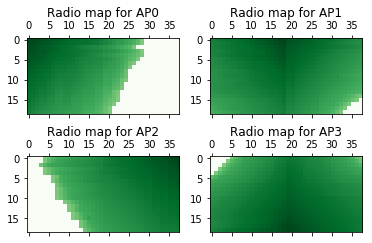

In [200]:
# Визуализация радио-покрытия для каждой точки доступа Wi-Fi в области позиционирования 
# Чем темнее и насыщеннее зеленый цвет, тем выше уровень сигнала от данной точки доступа в данной точке области позиционирования

for index, axis in enumerate([plt.subplot(position) for position in range(221,225)]):
    axis.matshow(radio_map[index], cmap=plt.cm.Greens)
    axis.set_title("Radio map for AP" + str(index),  y = 1.20)

<b>Суть алгоритма позиционирования</b>: каждая точка области позиционирования представляется в виде вектора (одномерного массива) размера N, где N - количество точек доступа Wi-Fi в области позиционирования. Каждый i-й элемент вектора является значением RSSI в данной точке области, замеренным от i-й точки доступа. Например, точку рассматриваемой области позиционирования с координатами (5;10) можно представить в виде следующего вектора: [x1, x2, x3, x4], где x1 - значение RSSI в данной точке области, созданное точкой доступа AP0; x2 - значение RSSI в данной точке области, созданное точкой доступа AP1 и т.д.

In [201]:
# Векторное представление конкретной точки области позиционирования можно получить при помощи среза массива radio_map
# по всем его подмассивам с указанием координат данной точки пересечения в области позиционирования

print("Векторное представление точки с координатами (5,10):", radio_map[:,5,10])
print("Векторное представление точки с координатами (1,30):", radio_map[:,1,30])

Векторное представление точки с координатами (5,10): [-50 -43 -93 -72]
Векторное представление точки с координатами (1,30): [-255  -53  -30  -82]


Когда в области позиционирования появляется мобильный клиент, то каждая из имеющихся точек доступа должна определить значение RSSI в точке клиента. За синхронизацию работы точек доступа отвечает специальный <b>location tracking server</b> - он периодически посылает запрос на точки доступа, а те ему отдают хэш-таблицу со значениями RSSI для каждого пользователя в своей области действия. Таким образом, точка присутствия мобильного клиента также представляется в виде вектора размера N, где N - количество точек доступа в области позиционирования. Если клиент находится за пределами сети i-й точки доступа, то i-е значение вектора местоположения клиента будет равно -255.   

In [202]:
# Пример представления местоположения мобильного клиента в виде вектора
# Мобильный клиент, находясь в определенной точке области позиционирования, ловит сигнал от AP0 с RSSI=-57, 
# от AP1 с RSSI=-83, от AP2 с RSSI=-255 (вне зоны доступа) и от AP3 с RSSI=-72   

user = np.array([-57,-83,-255,-72])

<b>Итого имеем следующее</b>: каждая из HxV точек области позиционирования представляется в виде вектора размера N, так же как и точка области, в которой находится клиент. <b>Ключевая идея заключается в том, что все эти векторы образуют N-мерное пространство и являются в нем отдельными точками</b>. А это значит, что определить местоположение мобильного клиента можно следующим образом: клиент находится в точке с координатами $(h;v)$, N-мерное представление которой ближе всего находится к N-мерному вектору мобильного клиента. Иначе говоря, если в N-мерном пространстве рассчитывать расстояние между вектором мобильного клиента и векторами, которыми представлены каждая из HxV точек пересечения, то мобильный клиент будет находится в точке области, расстояние до которой минимально. Расстояние между точками N-мерного пространства рассчитывается согласно <b>метрике Евклида</b>: $|\;user - location\;|$ - это модуль разности между векторами мобильного клиента $user$ и конкретной точки области позиционирования $location$. 

Итого <b>задача определения местоположения мобильного клиента сводится к решению следующей задачи оптимизации</b>:

$$\min_{(h;v)}{|\:user - location_{(h;v)}\: |}$$
То есть, необходимо подобрать такую координату $(h;v)$, которая смогла бы минимизировать расстояние между N-мерным вектором мобильного клиента $user$ и N-мерным вектором соответствующей точки области позиционирования $location$. <b>Решение данной задачи</b> даст координаты $(h;v)$ точки области позиционирования, где находится мобильный клиент. 

In [203]:
# Решение задачи оптимизации с записью отладочной информации
# Отладка заключается в формировании и возращении матрицы размера HxV, каждый элемент которой расчитывается
# как Евклидова дистанция между вектором пользователя и вектором соответствующей точки (h;v) области позиционирования   

def locate_user(user_vector, radio_map):
    """
    Функция принимает векторное представление мобильного клиента (user_vector) и карту радио-окружения radio_map.
    Функция возвращает координаты местоположения пользователя (user_location) и отладочную матрицу дистанций (distance_matrix).
    """
    # Инициализация матрицы дистанций 
    distance_matrix = np.zeros((19,38))
    # Итеративный перебор всех точек области позиционирования
    for h in range(0, 19):
        for v in range(0, 38):
            # Расчет расстояния между вектором клиента и конкретной точкой области позиционирования
            distance_matrix[h,v] = (sum((user_vector - radio_map[:,h,v]) ** 2)) ** 0.5
            # Определение координат пользователя
            user_location = np.unravel_index(distance_matrix.argmin(), distance_matrix.shape)
    return (user_location, distance_matrix)

Полученные координаты мобильного пользователя: (5, 15)
Расстояние между векторами пользователя и точки области позиционирования: 0.0


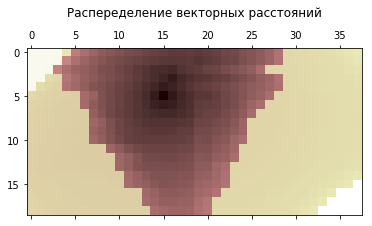

In [215]:
# Пример определения местоположения пользователя

# Отпределяем вектор RSSI мобильного пользователя
user_vector = np.array([-64, -32, -75, -54])
# Данный мобильный тользователь находится в точке (5;15) области позиционирования 

# Вызов функции и получение коордитат пользователя с матрицей дистанций
user_location, distance_matrix = locate_user(user_vector, radio_map)

print("Полученные координаты мобильного пользователя:", user_location)
print("Расстояние между векторами пользователя и точки области позиционирования:", distance_matrix[user_location[0], user_location[1]])
# Чем меньше дистанция между векторами пользователя и точки пересечения, тем лучше точность позиционирования

# Визуализация возможных местоположений пользователя на основе матрицы дистанций
# Чем темнее область, тем выше "вероятность" местонахождения мобильного клиента в данной точке области позиционирования 
distance_plot = plt.subplot(111)
distance_plot.matshow(distance_matrix, cmap=plt.cm.pink)
distance_plot.set_title("Распеределение векторных расстояний", y = 1.15);

Рассмотренная модель позволяет учесть влияние статических препятствий (в отличие от других моделей), присутствующих в области позиционирования, что деляет ее прогноз максимально приближенным к реальности. Однако на <b>точность позицинирования в данной модели влияют следующие факторы</b>:
1. Архитектура сети беспроводного доступа. Здесь имеют значение количество и расположение точек доступа Wi-Fi; количество точек, в которых осуществляется измерение RSSI; каналы, на которых работают различные точки доступа (по-хорошему должны быть непересекающимися); период опроса сервером точек доступа для сканирования радио-пространства. 
2. Наличие мобильных препятствий различных плотностей и количества в области позиционирования. Значения RSSI в каждой точке области позиционирования могут меняться из-за наличия мобильных препятствий.

<b>Как оценить влияние данных факторов?</b> 
1. Наличие мобильных препятствий в полной мере оценить невозможно, так как для этого необходимо знать карту радиопокрытия области позиционирования в каждый момент времени замера уровня RSSI мобильных пользователей, что технически нецелесообразно. Однако у Cisco в этом плане существует следующий подход: можно в течение определенного времени замерять значения RSSI от каждой точки доступа в каждой точке области позиционирования, а затем оценить статистически, как меняются значения RSSI в каждой точке радио-пространства, затем каждое из полученных значений RSSI усредняется и из этих усредненных значений формируется массив <b>radio_map</b>. 
2. Каналы, на которых работают точки доступа нужно выбирать для каждого проекта индивидуально. Период опроса точек доступа сервером необходимо моделировать отдельно.
3. Архитектурную модель беспроводной сети, а именно - количество и расположение точек доступа Wi-Fi, количество точек пространства для измерения RSSI, можно оценить эмпирически, задав условия для задачи оптимизации. 

<b>Оценка архитектурной модели позиционирования</b>

Для сравнения различных архитектурных моделей для позиционирования, которые могут отличаться друг от друга как количеством и расположением точек доступа Wi-Fi, так и количеством точек пространства для снятия RSSI, необходимо ввести метрику ошибки каждой модели при позиционировании. Соответственно, рассчитав ошибку позиционирования для каждой архитектурной модели, можно эти модели сравнить - <b>наилучшая модель будет давать наименьшую ошибку позиционирования</b>. Важно заметить, что ошибку позиционирования важно замерять в одинаковых условиях для всех моделей (например, минимизировав влияние мобильных препятствий в области позиционирования при проведении эксперимента). Ошибку позиционирования для конкретного мобильного пользователя можно определить следующим образом:

$$error\_user = |\;[(h_p - h_r) \cdot vertical\_footage\;;\; (v_p - v_r) \cdot horisontal\_footage]\;|$$

Ошибка позиционирования определяется как модуль вектора, соединяющего две точки области позиционирования: $(h_p;v_p)$ - координата пользователя, определенная при помощи модели, $(h_r,v_r)$ - действительная коорданата пользователя (в ней он находился, когда система определяла его местоположение). Переменная $vertical\_footage$ - это расстояние, которое выдерживается между двумя соседними точками области позиционирования вдоль всех вертикальных осей (в метрах). Аналогично $horisontal\_footage$ - расстояние, которое выдерживается между двумя точками вдоль всех горизонтальных осей (в метрах). То есть, <b>для определения ошибки позиционирования конкретного пользователя также используется метрика Евклида</b>, только применительно к двухмерному пространству в области позциионирования. Введение переменных $vertical\_footage$ и $horisontal\_footage$ позволяет рассматривать функцию ошибки позиционирования $error\_user$ как расстояние в метрах между координатой пользователя, которая была определена при помощи модели, и действительной координатой пользователя, где он находился в момент определения местоположения.

<b>Смысл формулы error_user</b>: если координата пользователя определена верно (то есть $(h_p;v_p) = (h_r;v_r)$), ошибка позиционирования будет равна 0 ($error\_user = 0$), если между определенной и действительной координатой пользователя есть расхождение, то величина ошибки будет определена как расстояние (в метрах) между данными координатами в области позиционирования. 

Теперь, задавшись метрикой ошибки позиционирования $error\_user$, опишем <b>ошибку позиционирования для архитектурной модели в целом</b>:

$$error\_model = \frac{1}{m}\sum_{i=1}^m{error(i)}$$

Ошибка позиционирования для архитектурной модели определяется как <b>средняя ошибка позиционирования по всем $m$ мобильным пользователям, которые участвовали в эксперименте</b>. Чем больше мобильных пользователей задействовано в эксперименте, тем точнее можно определить ошибку позиционирования архитектурной модели. При этом важно, чтобы мобильные пользователи были равномерно распределены по всей области позиционирования. 

In [216]:
# Оценка средней ошибки позиционирования рассматриваемой модели
# В эксперименте приняли участие 18 мобильных пользователей, которые были равномерно распределены 
# по всей области позиционирования

# Матрица замеров RSSI для каждого из 18 мобильных пользователей
# Замеренные RSSI для каждого пользователя немного отличаются от эталонных (записанных в radio_map), для того,
# чтобы смоделировать изменчивость радио-ообстановки
users = np.array([
    [-16, -60, -255, -255],
    [-27, -69, -255, -94],
    [-52, -83, -255, -66],
    [-37, -41, -95, -92],
    [-58, -59, -111, -58],
    [-87, -75, -255, -46],
    [-62, -26, -72, -65],
    [-74, -44, -83, -44],
    [-97, -65, -102, -32],
    [-87, -30, -49, -56],
    [-108, -53, -66, -39],
    [-255, -71, -77, -27],
    [-255, -47, -36, -70],
    [-255, -69, -52, -52],
    [-255, -97, -64, -39],
    [-255, -74, -25, -90],
    [-255, -95, -37, -68],
    [-255, -255, -53, -50]
])

# Матрица действительных координат для каждого из 18 пользователей
real_locations = np.array([
    [1,1],
    [6,1],
    [14,1],
    [1,8],
    [9,9],
    [17,9],
    [2,15],
    [9,15],
    [16,15],
    [1,22],
    [9,22],
    [16,22],
    [2,28],
    [9,28],
    [16,29],
    [3,35],
    [9,35],
    [16,35]
])

In [217]:
# Функция расчета средней ошибки позиционирования для архитектурной модели 

def compute_model_error(users, real_locations, radio_map, horisontal_footage=1, vertical_footage=1):
    """
    Функция в качестве обязательных аргументов принимает матрицу замеров RSSI для мобильных пользователей (users), 
    матрицу действительных координат данных мобильных пользователей (real_locations) и шаблон радио-обстановки (radio_map).
    Горизонтальный и вертикальный метраж по умолчанию установлены в 1 метр.
    Функция возвращает среднюю ошибку позиционирования модели (в метрах).
    """
    model_error = 0
    # Итеративный проход по замерам RSSI для каждого мобильного пользователя
    for i in range(users.shape[0]):
        # Определение координаты пользователя
        predicted_location, _ = locate_user(users[i], radio_map)
        # Определение координат вектора между полученной и действительной координатами
        distance_vector = predicted_location - real_locations[i]
        # Масштабирование вектора согласно заданному метражу
        distance_vector[0] *= vertical_footage
        distance_vector[1] *= horisontal_footage;
        # Накапливание ошибки позиционирования на каждом пользователе
        model_error += (sum(distance_vector ** 2)) ** 0.5
    return model_error/users.shape[0]

In [218]:
# Определение средней оцибки позиционирования для рассматриваемой модели

print("Средняя ошибка позиционирования модели:", compute_model_error(users, real_locations, radio_map), "м")

Средняя ошибка позиционирования модели: 0.24523408679850528 м


То есть, рассматриваемая архитектурная модель при определении местоположения пользователей ошибалась в среднем на 0,25 м, что дает очень хорошую точность позиционирования. Чем больше пользователей участвует в эксперименте, тем больше эта ошибка стремится к погрешности самой модели на всей генеральной совокупности возможных замеров RSSI в области позиционирования.

<b>Сравнение различных архитектурных моделей позиционирования</b>

Для рассматриваемого пространства позиционирования, размеченного сеткой из HxV точек, проведем оценку нескольких архитектурных моделей позиционирования с целью выявления технически лучшей из них. Для этого необходимо для каждой из архитектурных моделей рассчитать среднюю ошибку позиционирования на заданном множестве точек, в которых будет осуществяться определение местоположения (данные точки равномерно распределены по всей области позиционирования и одинаковы для каждой из моделей).  

In [208]:
# Определим 4 различных архитектурных модели позиционирования

models = {1: "AP0,AP1,AP2,AP3",  # Модель со всеми точками доступа, которая рассматривалась ранее
          2: "AP0,AP1,AP2",  # Модель, которая имеет только 3 точки доступа, расставленных в соответсвии с предыдущим рисунком
          3: "AP1,AP3",  # Модель с только с 2-мя точками доступа, расставленных по рисунку
          4: "AP0"}  # Модель из 1-й точки доступа

In [209]:
# Произведем замеры RSSI в каждой точке множества real_locations для каждой архитектурной модели
# за исключением первой, так как для нее ранее уже был проведен данный эксперимент

# Замеры RSSI в каждой точке множества real_locations для 2-й модели
users2 = np.array([
    [-16, -60, -255],
    [-27, -69, -255],
    [-52, -83, -255],
    [-37, -41, -95],
    [-58, -59, -111],
    [-87, -75, -255],
    [-62, -26, -72],
    [-74, -44, -83],
    [-97, -65, -102],
    [-87, -30, -49],
    [-108, -53, -66],
    [-255, -71, -77],
    [-255, -47, -36],
    [-255, -69, -52],
    [-255, -97, -64],
    [-255, -74, -25],
    [-255, -95, -37],
    [-255, -255, -53]
])

# Замеры RSSI в каждой точке множества real_locations для 3-й модели
users3 = np.array([
    [-60, -255],
    [-69, -94],
    [-83, -66],
    [-41, -92],
    [-59, -58],
    [-75, -46],
    [-26, -65],
    [-44, -44],
    [-65, -32],
    [-30, -56],
    [-53, -39],
    [-71, -27],
    [-47, -70],
    [-69, -52],
    [-97, -39],
    [-74, -90],
    [-95, -68],
    [-255, -50]
])

# Замеры RSSI в каждой точке множества real_locations для 4-й модели
users4 = np.array([
    [-16],
    [-27],
    [-52],
    [-37],
    [-58],
    [-87],
    [-62],
    [-74],
    [-97],
    [-87],
    [-108],
    [-255],
    [-255],
    [-255],
    [-255],
    [-255],
    [-255],
    [-255]
])

# Объединение замеров RSSI для каждой модели в один массив
all_users = [users, users2, users3, users4]

# Объединение шаблонов радио-окружений для всех моделей в один массив
all_radio_maps = [radio_map, radio_map[[0,1,2],:,:], radio_map[[1,3],:,:], radio_map[[0],:,:]]

In [210]:
# Рассчитаем среднюю ошибку позиционирования для каждой архитектурной модели на основе проведенных экспериментов

# Инициализация массив model_errors для накапливания ошибок по каждой модели
model_errors = np.zeros(len(all_radio_maps))

# Расчет средних ошибок позиционирования для каждой модели
for i in range(len(all_radio_maps)):
    model_errors[i] = compute_model_error(all_users[i], real_locations, all_radio_maps[i])
    print("Модель %s: средняя ошибка позиционирования = %s" % (i+1, model_errors[i]))

Модель 1: средняя ошибка позиционирования = 0.24523408679850528
Модель 2: средняя ошибка позиционирования = 0.5690355937288492
Модель 3: средняя ошибка позиционирования = 5.1231326195317175
Модель 4: средняя ошибка позиционирования = 9.556428402656998


In [211]:
# Определение наилучшей модели по наименьшей средней ошибке позиционирования

best_model_number = np.argmin(model_errors) + 1
print("Лучшая модель: %s. Описание модели: '%s'" % (best_model_number, models[best_model_number]))

Лучшая модель: 1. Описание модели: 'AP0,AP1,AP2,AP3'


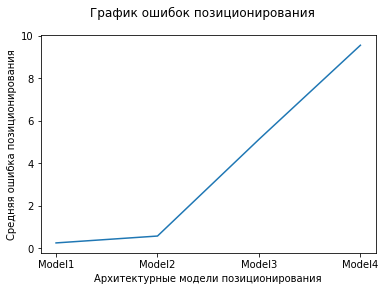

In [212]:
# Визуализация средней ошибки позиционирования для каждой модели

plt.plot(range(1, len(all_radio_maps) + 1), model_errors)
plt.xticks(range(1, len(all_radio_maps) + 1), ["Model" + str(i + 1) for i in range(len(all_radio_maps))])
plt.suptitle("График ошибок позиционирования")
plt.xlabel("Архитектурные модели позиционирования")
plt.ylabel("Средняя ошибка позиционирования");

Данный подход к оценке моделей позволяет сравнивать не только модели, основанные на технике location patterning (что было рассмотрено), но и модели, использующие другие подходы к определению местоположения пользователя. 

Для того, чтобы получить информацию к улучшению архитектурной модели позиционирования, можно посмотреть, <b>в каких точках области позиционирования модель ошибается больше всего</b>. Исходя из этой информации можно понять, что позволит улучшить модель, например: добавление еще одной точки доступа, увеличение мощности передачи на точках доступа, увеличение количества точек пространства для снятия RSSI и т.п. 